/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


((12, 1, True), -0.23893805309734503)
((18, 4, True), -0.30463576158940364)
((6, 5, False), -0.3664335664335667)
((5, 6, False), -0.37204301075268825)
((12, 7, True), 0.0697674418604651)
((14, 3, True), -0.10898661567877622)
((14, 6, True), -0.10766045548654248)
((5, 9, False), -0.2931818181818183)
((20, 5, True), 0.6451965065502187)
((12, 2, True), -0.08641975308641976)


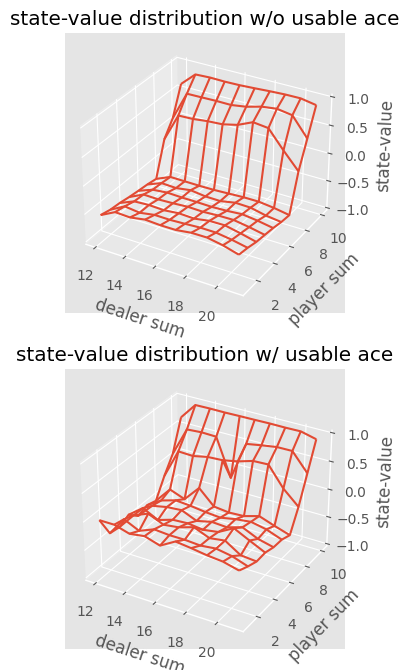

In [35]:
import gym
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from functools import partial
%matplotlib inline
plt.style.use('ggplot')

# Observation here encompasses all data about the state that we need, as well as reactions to it
env = gym.make('Blackjack-v1')  # Use Blackjack-v1 instead of Blackjack-v0

# Define a policy where we hit until we reach 19.
# Actions here are 0-stand, 1-hit
def sample_policy(observation):
    score, dealer_score, usable_ace = observation
    return 0 if score >= 19 else 1

def generate_episode(policy, env):
    # We initialize the list for storing states, actions, and rewards
    states, actions, rewards = [], [], []
    # Initialize the gym environment
    observation = env.reset()
    while True:
        # Append the states to the states list
        states.append(observation)
        # Now, we select an action using our sample_policy function and append the action to actions list
        action = sample_policy(observation)
        actions.append(action)
        # We perform the action in the environment according to our sample_policy, move to the next state
        observation, reward, done, info = env.step(action)
        rewards.append(reward)
        # Break if the state is a terminal state (i.e., done)
        if done:
            break
    return states, actions, rewards

# Finally, let's define the first-visit Monte Carlo prediction function.
# Firstly, we initialize an empty dictionary to store the current state-values
# along with another dictionary storing the number of entries for each state across episodes.
def first_visit_mc_prediction(policy, env, n_episodes):
    # First, we initialize the empty value table as a dictionary for storing the values of each state
    value_table = defaultdict(float)
    N = defaultdict(int)

    for _ in range(n_episodes):
        # Next, we generate the episode and store the states and rewards
        states, _, rewards = generate_episode(policy, env)
        returns = 0
        # Then for each step, we store the rewards to a variable R and states to S, and we calculate
        for t in range(len(states) - 1, -1, -1):
            R = rewards[t]
            S = states[t]
            returns += R
            # Now to perform first visit MC, we check if the episode is visited for the first time, if yes,
            # This is the standard Monte Carlo Incremental equation.
            # NewEstimate = OldEstimate + StepSize(Target - OldEstimate)
            if S not in states[:t]:
                N[S] += 1
                # Avoid division by zero
                if N[S] != 0:
                    value_table[S] += (returns - value_table[S]) / N[S]
    return value_table

value = first_visit_mc_prediction(sample_policy, env, n_episodes=500000)

for i in range(10):
    print(value.popitem())

def plot_blackjack(V, ax1, ax2):
    player_sum = np.arange(12, 21 + 1)
    dealer_show = np.arange(1, 10 + 1)
    usable_ace = np.array([False, True])
    state_values = np.zeros((len(player_sum), len(dealer_show), len(usable_ace)))
    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_show):
            for k, ace in enumerate(usable_ace):
                state_values[i, j, k] = V[player, dealer, ace]
    X, Y = np.meshgrid(player_sum, dealer_show)
    ax1.plot_wireframe(X, Y, state_values[:, :, 0])
    ax2.plot_wireframe(X, Y, state_values[:, :, 1])
    for ax in ax1, ax2:
        ax.set_zlim(-1, 1)
        ax.set_ylabel('player sum')
        ax.set_xlabel('dealer sum')
        ax.set_zlabel('state-value')

fig, axes = pyplot.subplots(nrows=2, figsize=(5, 8),subplot_kw={'projection': '3d'})
axes[0].set_title('state-value distribution w/o usable ace')
axes[1].set_title('state-value distribution w/ usable ace')
plot_blackjack(value, axes[0], axes[1])